In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections

* Разбивка пользователей на группы: генерация соли, создание функции для разбивки пользователей
* Дизайн теста: MDE, пример дизайна



# Разбивка пользователей на группы

In [3]:
!curl -O https://raw.githubusercontent.com/YuriyKotov/datasets/master/2019-Dec.csv.zip >> 2019-Dec.csv.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0Warning: Failed to open the file 2019-Dec.csv.zip: Permission denied

  0 73.7M    0  4134    0     0   1676      0 12:49:16  0:00:02 12:49:14  1677
curl: (23) Failure writing output to destination


In [5]:
shop_df = pd.read_csv('2019-Dec.csv.zip')

BadZipFile: File is not a zip file

In [ ]:
shop_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5


У нас есть пользовательские логи. Допустим, мы хотим провести дизайн теста на этих данных. Необходимо разбить пользователей на группы

1. Проверяем тип данных в колонке, по которой будем разбивать
2. Выбираем хэш-функцию, соль и создаем новую колонку хэшированного айди
3. Конвертируем в числовой вид и берем остаток от целочисленного деления на 2. По остатку выставляем группу

https://python.readthedocs.io/en/stable/library/hashlib.html

In [ ]:
shop_df['hash'] = ((shop_df['user_id'].astype(str)) + '#' + 'av8MC4yMseo=').apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

shop_df['hash_int'] = shop_df['hash'].str.slice(start=-6).apply(int, base=16)

shop_df['group'] = ((shop_df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

In [ ]:
shop_df.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,hash,hash_int,group,hash1,hash_int1,group1,hash2,hash_int2,group2
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,6c6abc4f2077ee735acc10873aeec1e84c73fdc61368db...,484344,A,5b676ad629652a4d713db01ba8bcdfcae696c4872b913d...,9919161,B,6c6abc4f2077ee735acc10873aeec1e84c73fdc61368db...,484344,A
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,1d801c27dc25cc0d23e8807a40e5b67b598ba43f953845...,3251533,B,29615577734a1c3964fdfa8d564fb216da320f26454b85...,1616237,B,1d801c27dc25cc0d23e8807a40e5b67b598ba43f953845...,3251533,B
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,fe7130fd86b413dba79ce99577835460ab1d98a665f962...,7807910,A,4ee8dc63655dace6f7d7a33137e00943fee3267734a003...,13069186,A,fe7130fd86b413dba79ce99577835460ab1d98a665f962...,7807910,A
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,ebbd986195fccc1fdd7193a8218b612bbe752ee6a2ecc1...,8920812,A,d87726014ebd86854fdfb50e752b79553345531caa8f39...,7242593,B,ebbd986195fccc1fdd7193a8218b612bbe752ee6a2ecc1...,8920812,A
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,36d2843862fbcf92392839a9cba65b6522717b91f514f8...,12591374,A,d2c08d0ffdf8f69414e39c374a83aa28ae851f44b895fd...,16398820,A,36d2843862fbcf92392839a9cba65b6522717b91f514f8...,12591374,A


In [ ]:
shop_df.groupby(['group'], as_index=False).count()

,group,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,hash,hash_int,hash1,hash_int1,group1
0,A,1752819,1752819,1752819,1752819,29077,1005037,1752819,1752819,1752419,1752819,1752819,1752819,1752819,1752819
1,B,1780467,1780467,1780467,1780467,29388,1017960,1780467,1780467,1780088,1780467,1780467,1780467,1780467,1780467


In [ ]:
shop_df.groupby(['group'], as_index=False).nunique()

,group,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,hash,hash_int
0,A,1098371,4,41325,467,10,249,2061,184843,415021,184843,182859
1,B,1104935,4,41902,471,10,251,2061,185311,424821,185311,183287


In [ ]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode # кодирует байтоподобный объект с помощью Base64 и возвращает закодированную байтовую строку.
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')

# '''os.urandom() method is used to generate a string of size random bytes suitable for cryptographic use
#    or we can say this method generates a string containing random characters.'''
# https://www.geeksforgeeks.org/python-os-urandom-method/

In [ ]:
M = [salt_generator() for _ in range(10)]

In [ ]:
L

['z8/udaZor0g=',
 'qVhbeCThQNs=',
 'iUx5PQrofmM=',
 'p9xQY4i/fEw=',
 'NChWszytB/U=',
 '5pB0ouLjXU4=',
 '93nMGu+OTNA=',
 'NFy3RkZdMLM=',
 '28ty2gFkUd8=',
 'iNlfVx4ZpXk=']

In [ ]:
M

['WeKZiKGbSro=',
 '0Ny62xIjzLY=',
 '+TSWwJe0/gI=',
 'iP/4OJfJzAA=',
 'uABRi2kfHQM=',
 'OFwCZvrsdHU=',
 '0cHJJWCIoyw=',
 '0ZRf2lXrW8Y=',
 '8gvCZP6lssM=',
 '3pmzcMwCOs8=']

In [ ]:
# Делим на 2 равные группы
def groups_splitter(df, columns, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

Проверим, как функция работает

In [ ]:
shop_df = shop_df.drop(columns=['group_x', 'group_y']) # дропаем колонки, если они остались от предыдущих упражнений

In [ ]:
shop_df.head(3) # проверяем, все ли окей

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554


In [ ]:
groups = groups_splitter(shop_df.copy(), ['user_id', 'group']) # передаем копию датафрейма, чтобы исходный не менялся
shop_df = pd.merge(shop_df, groups, how='left', on=['user_id']) # джойним датафрейм с логами с датафреймом юзер-группа

In [ ]:
shop_df.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,group
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,A
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,B
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,B
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,B
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,B


In [ ]:
max_date = shop_df['event_time'].max()
min_date = shop_df['event_time'].min()
print(min_date, max_date)

2019-12-01 00:00:00 UTC 2019-12-31 23:59:57 UTC


# Дизайн АВ-теста: формула MDE

<center>
<img src="https://raw.githubusercontent.com/YuriyKotov/datasets/master/mde.png" height="150" width="500">
</center>

Как вычислить квантили нормального распределения?

Таблицы со значениями можно посмотреть здесь: https://studfile.net/preview/3795082/page:2/

In [ ]:
from scipy.stats import norm

In [ ]:
norm.ppf(1-(0.05 / 2), loc=0, scale=1)

1.959963984540054

In [ ]:
norm.ppf(1-0.2, loc=0, scale=1)

0.8416212335729143

In [ ]:
# Теперь можем написать функцию:
def get_mde(metric_vec, alpha=0.05, beta=0.2):

    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()

    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)

    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)

    return mde*100/metric_mean

In [ ]:
# Опробуем на сгенерированной поюзерной метрике

shop_df_users = shop_df[['user_id', 'group']].drop_duplicates()
shop_df_users['metric'] = np.random.randint(100, size=shop_df_users.shape[0])

In [ ]:
shop_df_users.head()

In [ ]:
get_mde(shop_df_users['metric'], alpha=0.05, beta=0.2)

0.26862170380554434

In [ ]:
get_mde(shop_df_users['metric'], alpha=0.05, beta=0.3)

0.23820593420116978

# Пример дизайна

In [ ]:
import requests

# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)


kion dataset download: 100%|██████████| 78.8M/78.8M [2:06:54<00:00, 10.3kiB/s]

kion dataset download:  12%|█▏        | 9.44M/78.8M [00:00<00:00, 94.0MiB/s]
kion dataset download:  37%|███▋      | 29.4M/78.8M [00:00<00:00, 152MiB/s] 
kion dataset download:  64%|██████▍   | 50.3M/78.8M [00:00<00:00, 176MiB/s]
kion dataset download:  94%|█████████▍| 74.4M/78.8M [00:00<00:00, 199MiB/s]

In [ ]:
# Распаковываем архив из 3 файлов
import zipfile

with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

## 📺 Данные: датасет КИОН
- **просмотры** фильмов и сериалов в приложении KION
- данные о пользователях
- данные об айтемах (фильмы, сериалы и т.д.)

In [ ]:
interactions = pd.read_csv('data_kion/interactions_df.csv')
users = pd.read_csv('data_kion/users.csv')
items = pd.read_csv('data_kion/items.csv')


kion dataset download: 100%|██████████| 78.8M/78.8M [00:13<00:00, 199MiB/s]

In [ ]:
interactions.head(5)

# user_id - уникальный идентификатор пользователя
# item_id - уникальный идентификатор контента
# last_watch_dt - последняя дата просмотра юзером определенного контента
# total_dur - суммарная продолжительность просмотра определенного контента юзером (в секундах)
# watched_pct - процент просмотренного контента от общей продолжительности

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [ ]:
interactions.shape

(5476251, 5)

In [ ]:
users.head()

# user_id - уникальный идентификатор пользователя
# kids_flg = 0 - детей нет, если 1 - дети есть
# income - группа, в которую юзер отнесен по доходу
# age - группа, в которую юзер отнесен по возрасту
# sex - пол

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [ ]:
users.shape

(840197, 5)

In [ ]:
users.groupby('age', as_index=False).count()[['age', 'user_id']]

,age,user_id
0,age_18_24,127672
1,age_25_34,233926
2,age_35_44,207043
3,age_45_54,135925
4,age_55_64,75265
5,age_65_inf,46271


In [ ]:
items.head(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [ ]:
items.shape

(15963, 14)

In [ ]:
items.groupby('content_type', as_index=False).count()[['content_type', 'item_id']]

,content_type,item_id
0,film,12002
1,series,3961


In [ ]:
# предобработка данных
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


In [ ]:
# Оценим сколько у нас пользователей за 1 и 2 недели

In [ ]:
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()
print(min_date, max_date)

2021-03-13 2021-08-22


In [ ]:
interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=7)]['user_id'].nunique()

185907

In [ ]:
interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]['user_id'].nunique()

279129

In [ ]:
# выделим данные за одну (последнюю) неделю
week = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=7)]
week = week.groupby('user_id', as_index=False).agg({'total_dur': sum})

<ipython-input-152-eb5ee8923e02>:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  week = week.groupby('user_id', as_index=False).agg({'total_dur': sum})


In [ ]:
week.head()
# TVTu

,user_id,total_dur
0,1,1593
1,1000001,52
2,1000003,625
3,1000008,3691
4,1000009,2444


## Выбор метрики

- хотим использовать метрику длину просмотра на пользователя (total_dur в датасете) - так как это основная метрика, на которую смотрит бизнес

- То есть хотим, чтобы в тесте в группе B средняя длина просмотра на пользователя увеличилась

# Выбор эффекта

Пусть на первом этапе решили, что интересует эффект = 5% как разница между группами

### Посмотрим на распределение метрики

(помним: дисперсия должна быть невысокая)

<Axes: >

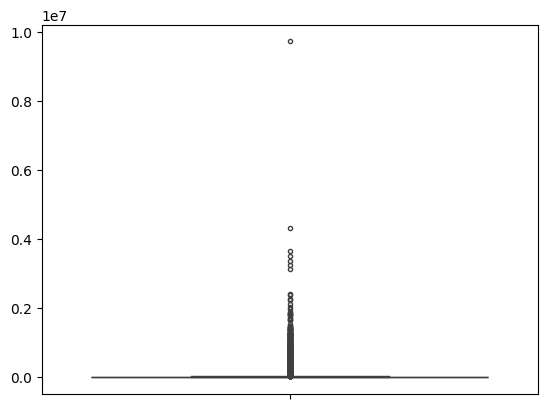

In [ ]:
sns.boxplot(week['total_dur'].values, fliersize=3)

In [ ]:
week['total_dur'].max()

9731801

In [ ]:
week['total_dur'].std()

62639.86487742628

In [ ]:
print(week.shape)
week = week[(week['total_dur'] < week['total_dur'].std() * 3)]
print(week.shape)

(185907, 2)
(183790, 2)


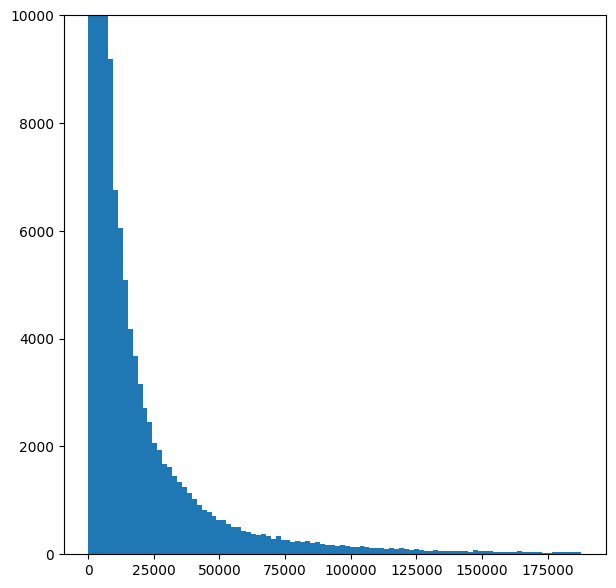

In [ ]:
week['total_dur'].hist(bins=100, figsize=(7,7))
plt.ylim([0, 10000])
plt.grid(False)

<details>
  <summary>📝 Подсказка </summary>
    
Данные не похожи на нормальное распределение: большинство людей смотрят понемногу, распределение не симметричное.

Что это значит? Что самые популярные критерии (t-test, z-test) для нашей метрики "длина просмотра" не подойдут, так как они требуют условия на нормальность распределения
    
</details>

## Выбор критерия
<details>
  <summary>📝 Подсказка </summary>
А что если использовать критерий Манна-Уитни?

- Нормальность данных не требуется
- Для него нужен ряд неповторяющихся уникальных значений
    
</details>

## Алгоритм подбора похожих групп

- Используем хэш функцию для этого. Посчитаем хэш от айди, найдем остаток от деления на 2 (так как 2 группы) и по остатку определим к какой группе относится пользователь. То есть по айди пользователя она разобьет всех пользователей на 2 группы.


## Переходим к валидации критерия
- оценка распределения p_value
- оценка мощности
- корректности

**Распределения p_value** при корректном подборе пары метрика + критерий -  равномерное распределение

**Достоверность (Корректность)** - вероятность того, что найдет различие, когда его нет

$$significance = Pr(\text{reject }H_0 | H_0 \text{ is true})$$

**Мощность** - вероятность того, что критерий найдет различие в случае, когда оно есть

$$power = Pr(\text{reject }H_0 | H_1 \text{ is true})$$

In [ ]:
week1_group = groups_splitter(week, columns=['user_id', 'total_dur', 'group'], user_salt='20241204')
week1_group.head()

,user_id,total_dur,group
0,1,1593,A
1,1000001,52,A
2,1000003,625,B
3,1000008,3691,B
4,1000009,2444,B


In [ ]:
week.groupby(by='group', as_index=False).count()

,group,user_id,total_dur,hash
0,A,91903,91903,91903
1,B,91887,91887,91887


In [ ]:
from scipy.stats import mannwhitneyu

# проверим, как работает код критерия
u, p = mannwhitneyu(week[week['group'] == 'A']['total_dur'].values,
                    week[week['group'] == 'B']['total_dur'].values)

print(f"p_value = {p}")

p_value = 0.09960455835462702


Проверка распределения p_value - должно быть равномерное

In [ ]:
pvalues = []

for i in tqdm(range(50)):  # 1000

  week1_hash = groups_splitter(week, columns=['user_id', 'total_dur', 'group'])

  u, p = mannwhitneyu(
        week1_hash[week1_hash['group'] == 'A']['total_dur'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur'].values
    )
  pvalues.append(p)

100%|██████████| 50/50 [00:53<00:00,  1.06s/it]


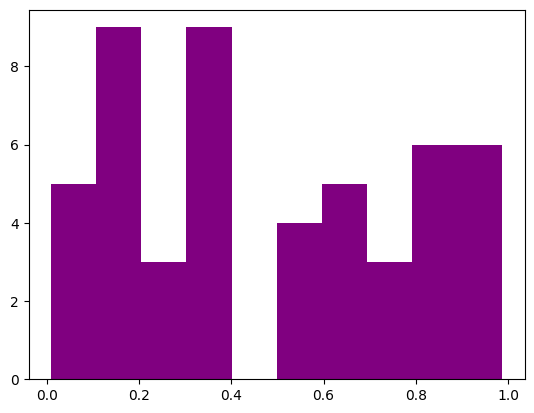

In [ ]:
plt.hist(pvalues, bins=10, color='purple');

<details>
  <summary>📝 Подсказка </summary>
Ой. Кажется критерий Манна-Уитни не подходит. А почему так произошло?
    </details>

<details>
  <summary>📝 Подсказка </summary>
Давайте еще проверим критерием Колмогорова-Смирнова (о том, что получившееся распределение pvalues есть равномерное распределение).
    </details>

In [ ]:
import scipy.stats

stat, p_value = scipy.stats.kstest(pvalues, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.10522293368449531 - p_values равномерное распределение


<details>
  <summary>📝 Подсказка </summary>
Посмотрим количество уникальных значений в выборке
</details>

In [ ]:
print(f"% уник. значений группы А = {round(week1_hash[week1_hash['group'] == 'A']['total_dur'].nunique() / week1_hash[week1_hash['group'] == 'A'].shape[0] * 100, 2)}")
print(f"% уник. значений группы B = {round(week1_hash[week1_hash['group'] == 'B']['total_dur'].nunique() / week1_hash[week1_hash['group'] == 'B'].shape[0] * 100, 2)}")

% уник. значений группы А = 34.24
% уник. значений группы B = 34.49


In [ ]:
week1_hash.groupby(by='total_dur', as_index=False).count()[['total_dur', 'user_id']].sort_values('user_id', ascending=False).head(20)

In [ ]:
week1_hash.groupby(by='total_dur', as_index=False).count()[['total_dur', 'user_id']].sort_values('user_id', ascending=False).tail(20)

Попробуем что то сделать с этой метрикой

Один из вариантов - логарифмирование метрики, способ снизить дисперсию

In [ ]:
week['total_dur_ln'] = np.log2(week['total_dur'])

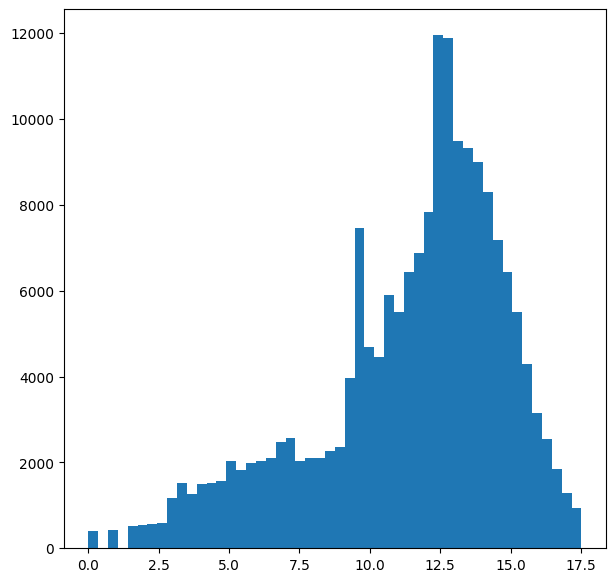

In [ ]:
week['total_dur_ln'].hist(bins=50, figsize=(7,7))
plt.grid(False)

In [ ]:
stat, p_value = scipy.stats.kstest(pvalues, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.10522293368449531 - p_values равномерное распределение


In [ ]:
pvalues = []

for i in tqdm(range(50)):  # 1000

  week1_hash = groups_splitter(week, columns=['user_id', 'total_dur_ln', 'group'])

  u, p = mannwhitneyu(
        week1_hash[week1_hash['group'] == 'A']['total_dur_ln'].values,
        week1_hash[week1_hash['group'] == 'B']['total_dur_ln'].values
    )
  pvalues.append(p)

100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


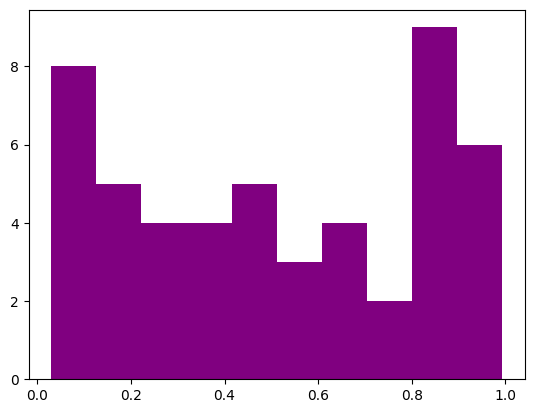

In [ ]:
plt.hist(pvalues, bins=10, color='purple');

In [ ]:
stat, p_value = scipy.stats.kstest(pvalues, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.3892163415621642 - p_values равномерное распределение


# Другой подход к дизайну - бутстрап

Критерий - бутстрап (bootstrap)

Как работает (теория)
- Для каждой группы A и B m раз генерируются псевдовыборки из исходной выборки как выборки с возвращением

- На каждой паре псевдовыборок считается некоторая статистика, которую мы оцениваем

- Дальше строим доверительный интервал для накопленных статистик между псевдовыборками [2.5%; 97.5 %]

- Считаем квантили

- Смотрим, где лежит наша статистика в этом распределении

Как реализуем на практике

Реализуем цикл (рекомендация - повторение не менее 1000 раз), на каждом шаге которого:

- создаем выборку с возвращением

- считаем ее среднее

- возвращаем квантили распределения средних (из цикла)

- далее будем смотреть, вошел ли 0 в этот интервал

In [ ]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

## Валидируем корректноcть (significance)

Моделируем AA-test: прогоняем бутстрап критерий, не добавляя эффект к группе В. Хотим, чтобы критерий НЕ нашел различий в выборках. Если точнее, то нашел не более чем  $\alpha$ случаях.

In [ ]:
correctness = []
values = []

for i in tqdm(range(50)): # в дз используем 1000 итераций

    new_df = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    correctness.append(not left_side <= 0 <= right_side)

    test_correctness = collections.Counter(correctness)

print(f'significance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

100%|██████████| 50/50 [04:05<00:00,  4.90s/it]

significance: 2.0%


In [ ]:
p_values = [get_p_value(dist) for dist in values]

Text(0.5, 1.0, 'Бутстреп распределение p_value')

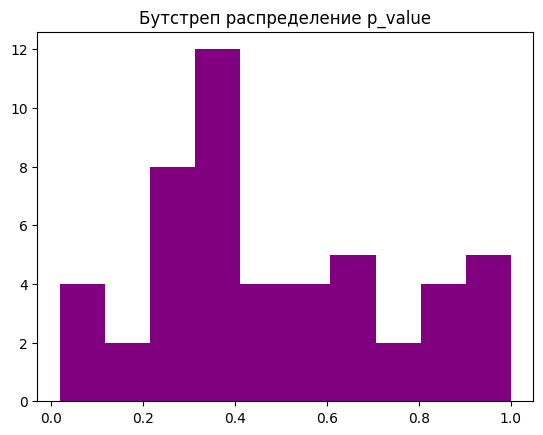

In [ ]:
plt.hist(p_values, bins=10, color='purple');
plt.title(f"Бутстреп распределение p_value")

In [ ]:
power = []
values = []

for i in tqdm(range(50)): # в дз используем 1000 итераций

    new_df = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur'] * (1+0.01) # докидаваем эффект в 1%

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power.append(not left_side <= 0 <= right_side)

    test_power = collections.Counter(power)

print(f'power: {test_power[1]/(test_power[1] + test_power[0])*100}%')

100%|██████████| 50/50 [04:07<00:00,  4.96s/it]

power: 22.0%


In [ ]:
power = []
values = []

for i in tqdm(range(50)): # в дз используем 1000 итераций

    new_df = groups_splitter(week.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()


    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur'] * (1+0.03)  # докидаваем эффект в 3%

    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power.append(not left_side <= 0 <= right_side)

    test_power = collections.Counter(power)

print(f'power: {test_power[1]/(test_power[1] + test_power[0])*100}%')

100%|██████████| 50/50 [03:58<00:00,  4.77s/it]

power: 92.0%


# ДЗ 1:


!!!  Все считаем на 1000 итерациях


### Дизайн теста бутстреп
1. Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

2. Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (2 балла)

3. На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (3 балла за расчет + 2 балла за подроброе объяснение)

4. Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (3 балла)


### Дизайн продолжение

1. Посчитать аналогичный дизайн для:
  - бутстреп + логарифмированная метрика длительности просмотров (4 балла)
  - манна-уитни + метрика длительности просмотров (4 балла)
  - манна-уитни + логарифмированная метрика длительности просмотров (4 балла)
  - t-test + метрика длительности просмотров (4 балла)
  - t-test + логарифмированная метрика длительности просмотров (4 балла)
2. Подробно описать выводы для каждой пары, какие варианты точно не подходят и почему. Объяснить зачем мы логарифмируем метрику и что нам это дает. Аргументированно выбрать 1 пару (метрика + критерий) которым вы будете оценивать АБ тест и какой эффект мы сможем отловить в нашем тесте. (5 баллов)


### A/B тест
1) Представим что у нас прошел тест, используем те же самые данные за 2 недели

2) Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (2 балла)

3) Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (1 балла)

4) Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (2 балла)

5) Посчитайте результат такого теста и сделайте выводы (10 баллов)



